# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import TimeSeriesSplit

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filtra os pontos se max_fpr for especificado
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    # AUC usando função apropriada
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)

    # Índice do ponto ótimo
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc



def plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=None):
    """
    Plota a curva ROC a partir de fpr, tpr e thresholds já calculados.
    Destaca o melhor threshold.
    """
    optimal_idx = np.where(thresholds == best_threshold)[0][0]

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.3f})', lw=2)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', zorder=5,
                label=f'Melhor Threshold = {best_threshold:.3f}')

    # Linhas auxiliares para melhor visualização
    plt.axhline(y=tpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)
    plt.axvline(x=fpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [6]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [7]:
train = pd.read_parquet('./data/skab_train_agg_dwt.parquet.gzip') 
test = pd.read_parquet('./data/skab_test_agg_dwt.parquet.gzip') 

In [8]:
train = train.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})
test = test.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})

In [9]:
train.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,32.115408,0.324407,32.000,32.9962,0.999943,0.279597,2020-03-09 10:14:00,value1,0.0
1,32.293166,0.493304,31.004,32.9962,0.999856,0.455720,2020-03-09 10:15:00,value1,0.0
2,32.105353,0.308289,32.000,32.9964,0.999943,0.255478,2020-03-09 10:16:00,value1,0.0
3,32.070182,0.256715,32.000,32.9964,0.999963,0.233720,2020-03-09 10:17:00,value1,0.0
4,32.157911,0.366335,32.000,32.9966,0.999929,0.339662,2020-03-09 10:18:00,value1,0.0


In [10]:
test.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
256,29.859143,1.468449,28.0263,32.9745,0.999925,1.977376,2020-03-09 14:31:00,value1,1.0
257,32.051431,0.423857,31.0265,32.9743,0.999911,0.431980,2020-03-09 14:32:00,value1,0.0
258,32.232359,0.490260,31.0265,33.0000,0.999890,0.469790,2020-03-09 14:33:00,value1,0.0
259,32.140928,0.339742,32.0000,32.9740,0.999939,0.317402,2020-03-09 14:34:00,value1,0.0
260,32.263825,0.429386,32.0000,33.0000,0.999905,0.395182,2020-03-09 14:35:00,value1,0.0


In [11]:
train.target.value_counts()

target
0.0    193
1.0    126
Name: count, dtype: int64

In [12]:
feature_model= [col for col in train.columns if col not in ['changepoint', 'timestamp', 'valve', 'target']]
feature_model

['Volume Flow RateRMS_mean',
 'Volume Flow RateRMS_std',
 'Volume Flow RateRMS_min',
 'Volume Flow RateRMS_max',
 'Volume Flow RateRMS_energy_L0',
 'Volume Flow RateRMS_std_L0']

In [13]:
development = train.reset_index(drop=True)

# development = development[(development['well']=='WELL-00006')].reset_index(drop=True)

development.shape

(319, 9)

In [14]:
validation = test.reset_index(drop=True)
validation.shape

(80, 9)

In [15]:
validation.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,29.859143,1.468449,28.0263,32.9745,0.999925,1.977376,2020-03-09 14:31:00,value1,1.0
1,32.051431,0.423857,31.0265,32.9743,0.999911,0.431980,2020-03-09 14:32:00,value1,0.0
2,32.232359,0.490260,31.0265,33.0000,0.999890,0.469790,2020-03-09 14:33:00,value1,0.0
3,32.140928,0.339742,32.0000,32.9740,0.999939,0.317402,2020-03-09 14:34:00,value1,0.0
4,32.263825,0.429386,32.0000,33.0000,0.999905,0.395182,2020-03-09 14:35:00,value1,0.0


In [16]:
# validation_well = validation[(validation['well']=='WELL-00006')].reset_index(drop=True)

# validation_well.shape

In [17]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(193, 9)

In [18]:
development

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,32.115408,0.324407,32.0000,32.9962,0.999943,0.279597,2020-03-09 10:14:00,value1,0.0
1,32.293166,0.493304,31.0040,32.9962,0.999856,0.455720,2020-03-09 10:15:00,value1,0.0
2,32.105353,0.308289,32.0000,32.9964,0.999943,0.255478,2020-03-09 10:16:00,value1,0.0
3,32.070182,0.256715,32.0000,32.9964,0.999963,0.233720,2020-03-09 10:17:00,value1,0.0
4,32.157911,0.366335,32.0000,32.9966,0.999929,0.339662,2020-03-09 10:18:00,value1,0.0
...,...,...,...,...,...,...,...,...,...
314,32.036802,0.399892,31.0429,32.9584,0.999893,0.297338,2020-03-09 16:54:00,value2,0.0
315,31.876698,0.366949,31.0429,32.9584,0.999939,0.444783,2020-03-09 16:55:00,value2,0.0
316,31.982255,0.288388,31.0431,32.9581,0.999962,0.263289,2020-03-09 16:56:00,value2,0.0
317,31.947795,0.448944,31.0434,32.9581,0.999869,0.334147,2020-03-09 16:57:00,value2,0.0


In [19]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [20]:
y_dev.sum()

126.0

In [21]:
len(y_dev)

319

In [22]:
X_no_anomalies = train_no_anomalies[feature_model].values

### Optimization with CMA-ES

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [23]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

In [24]:
def build_iforest(params):
    estimator = IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        random_state=42,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)
    ])

def transform_iforest_params(params):
    return {
        'n_estimators': int(params[0]),
        'contamination': float(params[1]),
        'max_samples': float(params[2]),
        'max_features': float(params[3])
    }

def evaluate_model(model, dataset, tscv, features):
    roc_auc_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = -model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

def objective_iforest(trial, dataset, tscv, features):
    n_estimators = trial.suggest_int('n_estimators', 5, 256)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    max_samples = trial.suggest_float('max_samples', 0.3, 1.0)
    max_features = trial.suggest_float('max_features', 0.3, 1.0)
    params = [n_estimators, contamination, max_samples, max_features]

    model_params = transform_iforest_params(params)
    model = build_iforest(model_params)
    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_iforest(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_iforest(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [25]:
import time

tscv = TimeSeriesSplit(n_splits=3)
start_time = time.time()  # Inicia o cronômetro

best_params_iforest, study_iforest = optuna_optimization_iforest(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para Isolation Forest: {best_params_iforest}")

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 21:32:59,518] A new study created in memory with name: no-name-cb0b1bba-2895-4959-932a-afa7bc923995
[I 2025-10-10 21:33:02,646] Trial 0 finished with value: 82.7087612689675 and parameters: {'n_estimators': 249, 'contamination': 0.00036447024801395, 'max_samples': 0.3111117049400556, 'max_features': 0.6924808660784523}. Best is trial 0 with value: 82.7087612689675.
[I 2025-10-10 21:33:05,263] Trial 1 finished with value: 87.39664051407291 and parameters: {'n_estimators': 160, 'contamination': 0.0004990259671431628, 'max_samples': 0.6008273062625635, 'max_features': 0.5936996137354411}. Best is trial 1 with value: 87.39664051407291.
[I 2025-10-10 21:33:08,609] Trial 2 finished with value: 86.02601971567067 and parameters: {'n_estimators': 157, 'contamination': 0.0021292707951505235, 'max_samples': 0.7235491755394081, 'max_features': 0.76507648680134}. Best is trial 1 with value: 87.39664051407291.
[I 2025-10-10 21:33:10,521] Trial 3 finished with value: 88.28994268023168 a

Melhores parâmetros para Isolation Forest: {'n_estimators': 132, 'contamination': 0.002679068664871287, 'max_samples': 0.7204978690766926, 'max_features': 0.6090720445321114}

--- Resultados Finais ---
Tempo total de execução: 2057.49 segundos
Tempo total de execução: 34.29 minutos


In [26]:
data_metrics_iforest = []

for trial in study_iforest.trials:
    data_metrics_iforest.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_iforest = pd.DataFrame(data_metrics_iforest)
df_results_iforest.to_csv('./metrics_skab/results_iforest_cmaes_dwt.csv', index=False)
df_results_iforest.head()

,trial,roc_auc_mean,roc_auc_std,value,n_estimators,contamination,max_samples,max_features
0,0,0.898069,0.070981,82.708761,249,0.000364,0.311112,0.692481
1,1,0.917567,0.043601,87.396641,160,0.000499,0.600827,0.593700
2,2,0.915113,0.054853,86.026020,157,0.002129,0.723549,0.765076
3,3,0.923351,0.040452,88.289943,130,0.002946,0.605721,0.861625
4,4,0.911812,0.053520,85.829222,101,0.003721,0.435387,0.712070


In [27]:
df_results_iforest = pd.read_csv('./metrics_skab/results_iforest_cmaes_dwt.csv')   

df_results_iforest['roc_auc_adjusted'] = df_results_iforest['roc_auc_mean'] - df_results_iforest['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_iforest.loc[999]
best_params = df_results_iforest.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                30.000000
roc_auc_mean          0.933117
roc_auc_std           0.034849
value                89.826872
n_estimators        132.000000
contamination         0.002679
max_samples           0.720498
max_features          0.609072
roc_auc_adjusted      0.898269
Name: 30, dtype: float64


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

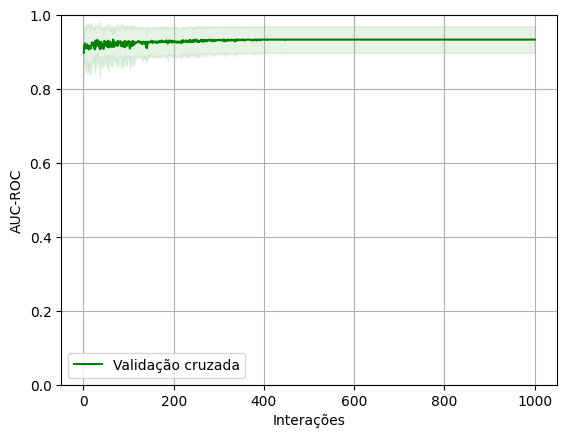

In [28]:
results_df_iforest2 = df_results_iforest[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_iforest2, title="iforest", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [29]:
n_estimators_best = int(best_params_iforest.get('n_estimators'))
contamination_best = round(float(best_params_iforest.get('contamination')), 5)
max_samples_best = round(float(best_params_iforest.get('max_samples')), 2)
max_features_best = round(float(best_params_iforest.get('max_features')), 2)

print(f"Melhores parâmetros para Isolation Forest: n_estimators={n_estimators_best}, contamination={contamination_best}, max_samples={max_samples_best}, max_features={max_features_best}")

Melhores parâmetros para Isolation Forest: n_estimators=132, contamination=0.00268, max_samples=0.72, max_features=0.61


In [30]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    random_state=42
)

pipe_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

pipe_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 IsolationForest(contamination=0.00268, max_features=0.61,
                                 max_samples=0.72, n_estimators=132,
                                 random_state=42))])

In [31]:
scores_dev = -pipe_model_iforest.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)


Melhor Threshold (FPR ≤ 1): -0.1409, AUC: 0.9285
Melhore threshold:  -0.14089582259993738


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90500   0.93782   0.92112       193
         1.0    0.89916   0.84921   0.87347       126

    accuracy                        0.90282       319
   macro avg    0.90208   0.89352   0.89729       319
weighted avg    0.90269   0.90282   0.90230       319

Specificity: 0.9378238341968912
Gini:  0.8569783699317377
ROC AUC::  0.9284891849658689


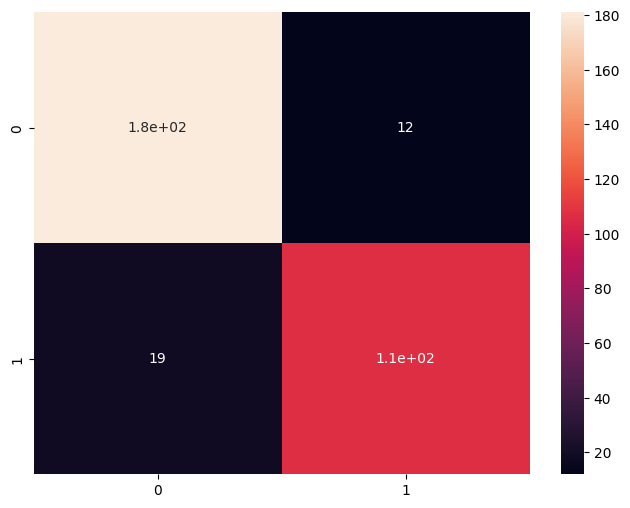

In [32]:
metrics(y_dev, y_pred, scores_dev)

In [33]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [34]:
scores_valid = -pipe_model_iforest.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = pipe_model_iforest.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

In [35]:
# scores_valid = -pipe_model_iforest.decision_function(X_valid)
# final_auc = roc_auc_score(y_valid, scores_valid)
# # Calcular a curva ROC  
# fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

# print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89796   0.93617   0.91667        47
         1.0    0.90323   0.84848   0.87500        33

    accuracy                        0.90000        80
   macro avg    0.90059   0.89233   0.89583        80
weighted avg    0.90013   0.90000   0.89948        80

Specificity: 0.9361702127659575
Gini:  0.8284977433913603
ROC AUC::  0.9142488716956801


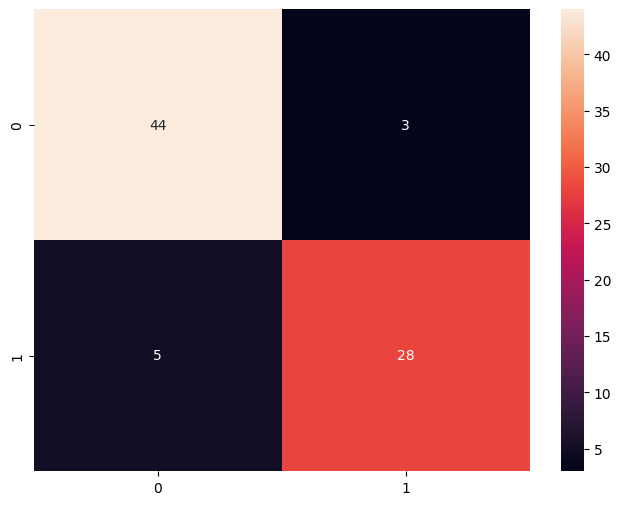

In [36]:
metrics(y_valid, y_pred, scores_valid)

In [37]:
validation['scores_forest']=-pipe_model_iforest.decision_function(X_valid)

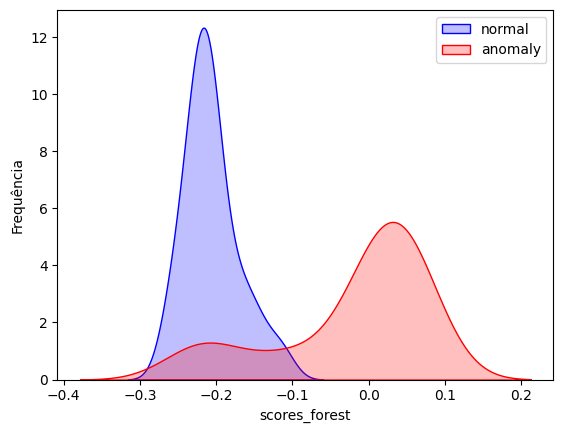

In [38]:
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 0) & (validation["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 1) & (validation["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [39]:
with open('./models_skab/pipeline_iForest_cmaes_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_iforest, file)

## Local Outlier Factor

In [40]:
from sklearn.neighbors import LocalOutlierFactor

In [41]:
def build_lof(params):
    model = LocalOutlierFactor(
        n_neighbors=int(params['n_neighbors']),
        contamination=params['contamination'],
        novelty=True,
        n_jobs=-1
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_lof_params(params):
    return {
        'n_neighbors': int(params[0]),
        'contamination': float(params[1])
    }

def objective_lof(trial, dataset, tscv, features):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 25)
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    params = [n_neighbors, contamination]

    model_params = transform_lof_params(params)
    model = build_lof(model_params)
    mean_score, std_score = evaluate_model(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

def optuna_optimization_lof(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_lof(trial, dataset, tscv, features), n_trials=n_trials)

    return study.best_params, study

In [42]:
import time
tscv = TimeSeriesSplit(n_splits=3)
start_time = time.time()  # Inicia o cronômetro

best_params_lof, study_lof = optuna_optimization_lof(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para LOF: {best_params_lof}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:07:21,093] A new study created in memory with name: no-name-7f4e60b5-663d-4758-86f7-c0ba59697685
[I 2025-10-10 22:07:21,266] Trial 0 finished with value: 86.99042581877794 and parameters: {'n_neighbors': 8, 'contamination': 0.001741962304798201}. Best is trial 0 with value: 86.99042581877794.
[I 2025-10-10 22:07:21,416] Trial 1 finished with value: 90.88406932048146 and parameters: {'n_neighbors': 17, 'contamination': 0.003943387538508594}. Best is trial 1 with value: 90.88406932048146.
[I 2025-10-10 22:07:21,573] Trial 2 finished with value: 91.13179048730152 and parameters: {'n_neighbors': 12, 'contamination': 0.002192807438898302}. Best is trial 2 with value: 91.13179048730152.
[I 2025-10-10 22:07:21,722] Trial 3 finished with value: 90.88067087461076 and parameters: {'n_neighbors': 18, 'contamination': 0.004036866363649483}. Best is trial 2 with value: 91.13179048730152.
[I 2025-10-10 22:07:21,870] Trial 4 finished with value: 90.83387170031443 and parameters: {'n_

Melhores parâmetros para LOF: {'n_neighbors': 13, 'contamination': 0.004097003643039989}
Tempo total de execução: 148.13 segundos
Tempo total de execução: 2.47 minutos


In [43]:
data_metrics_lof = []

for trial in study_lof.trials:
    data_metrics_lof.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_lof = pd.DataFrame(data_metrics_lof)
df_results_lof.to_csv('./metrics_skab/results_lof_cmaes_dwt.csv', index=False)
df_results_lof.head()

,trial,roc_auc_mean,roc_auc_std,value,n_neighbors,contamination
0,0,0.905788,0.035883,86.990426,8,0.001742
1,1,0.922436,0.013596,90.884069,17,0.003943
2,2,0.924660,0.013342,91.131790,12,0.002193
3,3,0.922104,0.013297,90.880671,18,0.004037
4,4,0.924228,0.015890,90.833872,11,0.002524


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

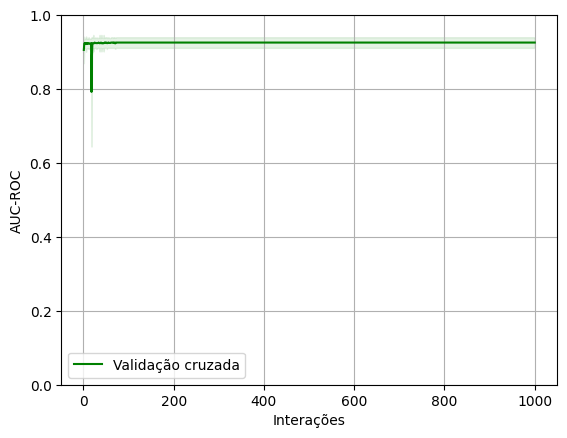

In [44]:
results_df_lof2 = df_results_lof[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_lof2, title="lof", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [45]:
df_results_lof = pd.read_csv('./metrics_skab/results_lof_cmaes_dwt.csv')   

df_results_lof['roc_auc_adjusted'] = df_results_lof['roc_auc_mean'] - df_results_lof['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_lof['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_lof.loc[999]
best_params = df_results_lof.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               24.000000
roc_auc_mean         0.925775
roc_auc_std          0.014414
value               91.136129
n_neighbors         13.000000
contamination        0.004097
roc_auc_adjusted     0.911361
Name: 24, dtype: float64


In [46]:
# best_params_lof = {
#  'contamination': 0.001554,
#  'n_neighbors': 25}

In [47]:
n_neighbors_best = int(round(best_params_lof.get('n_neighbors'), 0))
contamination_best = round(float(best_params_lof.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_neighbors={n_neighbors_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_neighbors=13, contamination=0.0041


In [48]:
estimator_lof  = LocalOutlierFactor(
    n_neighbors=n_neighbors_best,
    contamination=contamination_best,
    novelty=True,
    n_jobs=-1
)

estimator_lof 

LocalOutlierFactor(contamination=0.0041, n_jobs=-1, n_neighbors=13,
                   novelty=True)

In [49]:
pipe_model_lof = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator_lof)
        ])

In [50]:
pipe_model_lof.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.0041, n_jobs=-1,
                                    n_neighbors=13, novelty=True))])

In [51]:
scores_dev = -pipe_model_lof.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

# y_pred = pipe_model_lof.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)  

Melhor Threshold (FPR ≤ 1): -2.8550, AUC: 0.9299
Melhore threshold:  -2.855032579282734


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89706   0.94819   0.92191       193
         1.0    0.91304   0.83333   0.87137       126

    accuracy                        0.90282       319
   macro avg    0.90505   0.89076   0.89664       319
weighted avg    0.90337   0.90282   0.90195       319

Specificity: 0.9481865284974094
Gini:  0.8597746525207666
ROC AUC::  0.9298873262603833


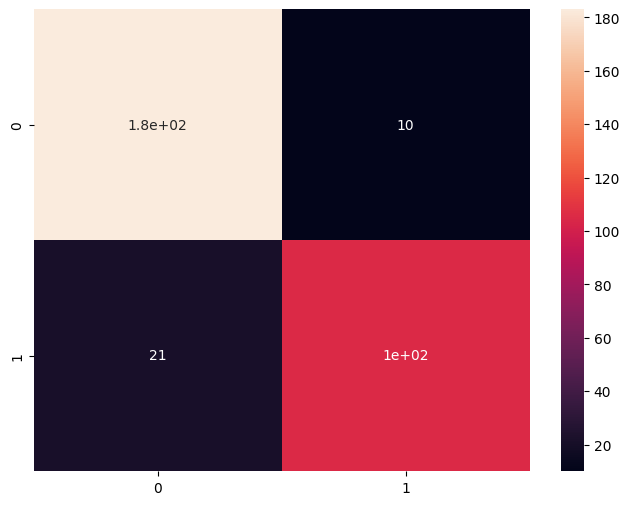

In [52]:
metrics(y_dev, y_pred, scores_dev)

In [53]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [54]:
scores_valid = -pipe_model_lof.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = pipe_model_lof.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.87805   0.76596   0.81818        47
         1.0    0.71795   0.84848   0.77778        33

    accuracy                        0.80000        80
   macro avg    0.79800   0.80722   0.79798        80
weighted avg    0.81201   0.80000   0.80152        80

Specificity: 0.7659574468085106
Gini:  0.8065764023210833
ROC AUC::  0.9032882011605416


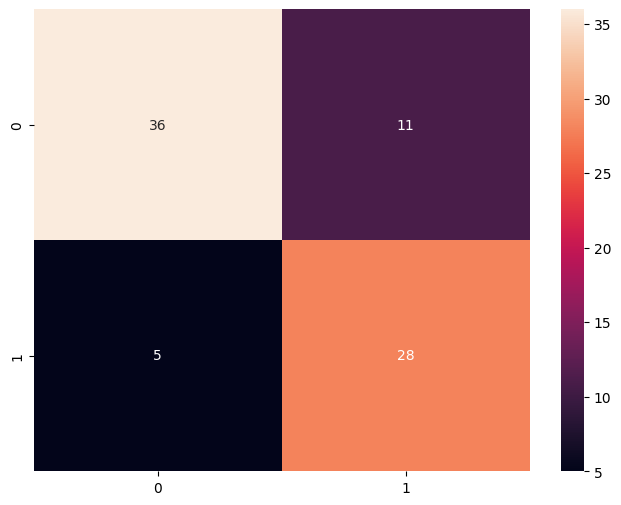

In [55]:
metrics(y_valid, y_pred, scores_valid)

In [56]:
with open('./models_skab/pipeline_LOF_cmaes_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_lof, file)

## Algorithms Pyod
https://pyod.readthedocs.io/en/latest/

In [57]:
def evaluate_model_pyod(model, dataset, tscv, features):
    roc_auc_scores = []
    for train_index, test_index in tscv.split(dataset):
        train_data = dataset.iloc[train_index]
        X_train = train_data[train_data['target'] == 0][features]
        X_test = dataset.iloc[test_index][features]
        y_test = dataset.iloc[test_index]['target']

        model.fit(X_train)
        y_scores = model.decision_function(X_test)

        score = roc_auc_score(y_test, y_scores)
        roc_auc_scores.append(score)

    mean_score = np.mean(roc_auc_scores)
    std_score = np.std(roc_auc_scores)

    return mean_score, std_score

#### PCA

In [58]:
from pyod.models.pca import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo PCA com pipeline
def build_pca(params):
    model = PCA(
        contamination=params['contamination'], 
        n_components=params['n_components']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Transformação de vetor para dicionário de parâmetros
def transform_pca_params(params):
    return {
        'contamination': float(params[0]), 
        'n_components': float(params[1])
    }

# Função objetivo do Optuna
def objective_pca(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_components = trial.suggest_float('n_components', 0.5, 1.0)

    # Parâmetros como vetor para função de transformação
    params = [contamination, n_components]
    model_params = transform_pca_params(params)

    model = build_pca(model_params)
    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com CMA-ES
def optuna_optimization_pca(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_pca(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [59]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_pca, study_pca = optuna_optimization_pca(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para pca: {best_params_pca}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:09:51,508] A new study created in memory with name: no-name-9445f7cd-528d-4057-9393-64df76eb1ad8
[I 2025-10-10 22:09:51,633] Trial 0 finished with value: 88.07813065889776 and parameters: {'contamination': 0.00024657542155854845, 'n_components': 0.515602220191907}. Best is trial 0 with value: 88.07813065889776.
[I 2025-10-10 22:09:51,752] Trial 1 finished with value: 90.10939664387625 and parameters: {'contamination': 0.0016795788065415308, 'n_components': 0.667000718947551}. Best is trial 1 with value: 90.10939664387625.
[I 2025-10-10 22:09:51,867] Trial 2 finished with value: 90.10939664387625 and parameters: {'contamination': 0.0029265102269256473, 'n_components': 0.7200457848813528}. Best is trial 1 with value: 90.10939664387625.
[I 2025-10-10 22:09:51,940] Trial 3 finished with value: 91.11173716362642 and parameters: {'contamination': 0.004421852632825305, 'n_components': 0.7994704261959928}. Best is trial 3 with value: 91.11173716362642.
[I 2025-10-10 22:09:52,0

Melhores parâmetros para pca: {'contamination': 0.004262387226604143, 'n_components': 0.8837278226472007}
Tempo total de execução: 39.00 segundos
Tempo total de execução: 0.65 minutos


In [60]:
data_metrics_pca = []

for trial in study_pca.trials:
    data_metrics_pca.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_pca = pd.DataFrame(data_metrics_pca)
df_results_pca.to_csv('./metrics_skab/results_pca_cmaes_dwt.csv', index=False)
df_results_pca.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_components
0,0,0.923809,0.043028,88.078131,0.000247,0.515602
1,1,0.932231,0.031137,90.109397,0.001680,0.667001
2,2,0.932231,0.031137,90.109397,0.002927,0.720046
3,3,0.930901,0.019784,91.111737,0.004422,0.799470
4,4,0.930901,0.019784,91.111737,0.001989,0.818344


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

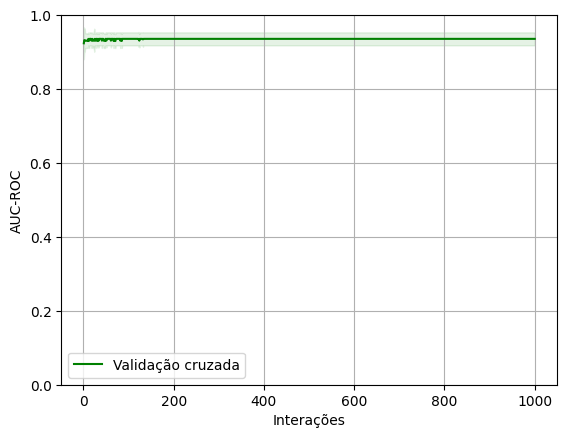

In [61]:
results_df_pca2 = df_results_pca[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_pca2, title="pca", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [62]:
df_results_pca = pd.read_csv('./metrics_skab/results_pca_cmaes_dwt.csv')   

df_results_pca['roc_auc_adjusted'] = df_results_pca['roc_auc_mean'] - df_results_pca['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_pca['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_pca.loc[999]
best_params = df_results_pca.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               10.000000
roc_auc_mean         0.935767
roc_auc_std          0.017591
value               91.817654
contamination        0.004262
n_components         0.883728
roc_auc_adjusted     0.918177
Name: 10, dtype: float64


In [63]:
n_components_best = float(round(best_params.get('n_components'), 2))
contamination_best = round(float(best_params.get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_components={n_components_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_components=0.88, contamination=0.00426


In [64]:
if n_components_best==1.0:
    n_components_best=0.99
else:
    pass

In [65]:
estimator = PCA(random_state=42, 
                contamination = contamination_best,
                n_components = n_components_best
                
                )
estimator

PCA(contamination=0.00426, copy=True, iterated_power='auto',
  n_components=0.88, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False)

In [66]:
# estimator = PCA(** best_params_pca, random_state=42)

pipe_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_pca.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 PCA(contamination=0.00426, copy=True, iterated_power='auto',
  n_components=0.88, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [67]:
# y_pred = pipe_model_pca.predict(development[feature_model])

scores_dev = pipe_model_pca.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 85.1365, AUC: 0.9164
Melhore threshold:  85.13650059932735


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90148   0.94819   0.92424       193
         1.0    0.91379   0.84127   0.87603       126

    accuracy                        0.90596       319
   macro avg    0.90764   0.89473   0.90014       319
weighted avg    0.90634   0.90596   0.90520       319

Specificity: 0.9481865284974094
Gini:  0.8327165062916357
ROC AUC::  0.9163582531458179


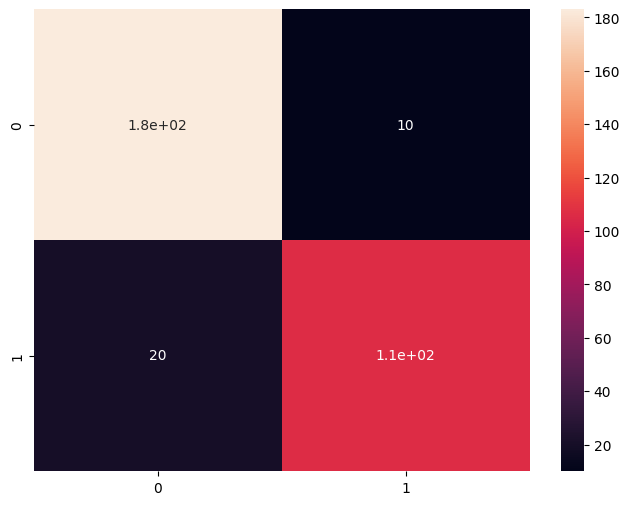

In [68]:
metrics(y_dev, y_pred, scores_dev)

In [69]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [70]:
scores_valid = pipe_model_pca.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = pipe_model_pca.predict(validation[feature_model])
# y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89362   0.89362   0.89362        47
         1.0    0.84848   0.84848   0.84848        33

    accuracy                        0.87500        80
   macro avg    0.87105   0.87105   0.87105        80
weighted avg    0.87500   0.87500   0.87500        80

Specificity: 0.8936170212765957
Gini:  0.8065764023210833
ROC AUC::  0.9032882011605416


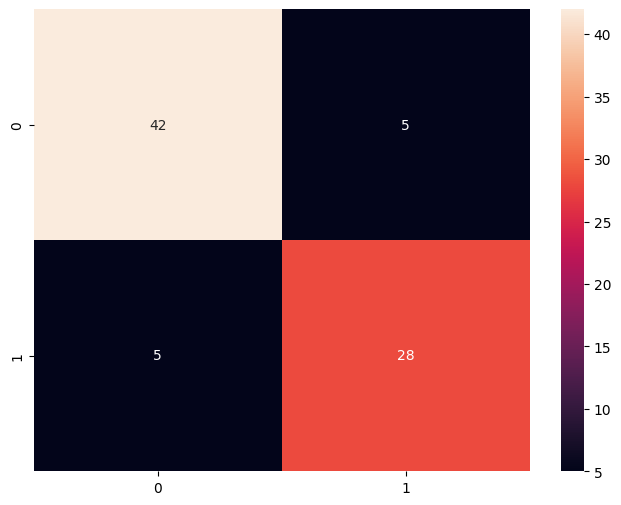

In [71]:
metrics(y_valid, y_pred, scores_valid)

In [72]:
with open('./models_skab/pipeline_PCA_cmaes_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_pca, file)

#### LODA

In [73]:
from pyod.models.loda import LODA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

# Função para construir o modelo LODA
def build_loda(params):
    model = LODA(
        contamination=params['contamination'],
        n_bins=params['n_bins'],
        n_random_cuts=params['n_random_cuts']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Função para transformar vetor de parâmetros em dicionário
def transform_loda_params(params):
    return {
        'contamination': float(params[0]),
        'n_bins': int(params[1]),
        'n_random_cuts': int(params[2])
    }

# Função objetivo para o Optuna
def objective_loda(trial, dataset, tscv, features):
    contamination = trial.suggest_float('contamination', 0.0001, 0.005)
    n_bins = trial.suggest_int('n_bins', 50, 5000)
    n_random_cuts = trial.suggest_int('n_random_cuts', 10, 1000)

    params = [contamination, n_bins, n_random_cuts]
    model_params = transform_loda_params(params)
    model = build_loda(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100*(mean_score - std_score) 

# Execução da otimização com CmaEsSampler
def optuna_optimization_loda(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_loda(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [74]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_loda, study_loda = optuna_optimization_loda(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para loda: {best_params_loda}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:10:32,031] A new study created in memory with name: no-name-29d5411e-39e6-4218-9145-9b936a6e9899
[I 2025-10-10 22:10:32,165] Trial 0 finished with value: 11.366338582095441 and parameters: {'contamination': 0.004874135574087895, 'n_bins': 899, 'n_random_cuts': 49}. Best is trial 0 with value: 11.366338582095441.
[I 2025-10-10 22:10:32,678] Trial 1 finished with value: 10.705515377285636 and parameters: {'contamination': 0.004170402565666033, 'n_bins': 3139, 'n_random_cuts': 534}. Best is trial 0 with value: 11.366338582095441.
[I 2025-10-10 22:10:33,185] Trial 2 finished with value: 11.721015022012702 and parameters: {'contamination': 0.0030145495940432387, 'n_bins': 1742, 'n_random_cuts': 761}. Best is trial 2 with value: 11.721015022012702.
[I 2025-10-10 22:10:33,661] Trial 3 finished with value: 8.24213937659274 and parameters: {'contamination': 0.0029214551796201862, 'n_bins': 2789, 'n_random_cuts': 564}. Best is trial 2 with value: 11.721015022012702.
[I 2025-10-1

Melhores parâmetros para loda: {'contamination': 0.002721362871230859, 'n_bins': 51, 'n_random_cuts': 317}
Tempo total de execução: 278.03 segundos
Tempo total de execução: 4.63 minutos


In [75]:
data_metrics_loda = []

for trial in study_loda.trials:
    data_metrics_loda.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_loda = pd.DataFrame(data_metrics_loda)
df_results_loda.to_csv('./metrics_skab/results_loda_cmaes_dwt.csv', index=False)
df_results_loda.head()

,trial,roc_auc_mean,roc_auc_std,value,contamination,n_bins,n_random_cuts
0,0,0.202746,0.089083,11.366339,0.004874,899,49
1,1,0.198602,0.091547,10.705515,0.004170,3139,534
2,2,0.206701,0.089491,11.721015,0.003015,1742,761
3,3,0.175146,0.092724,8.242139,0.002921,2789,564
4,4,0.203958,0.081769,12.218871,0.002961,1310,572


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

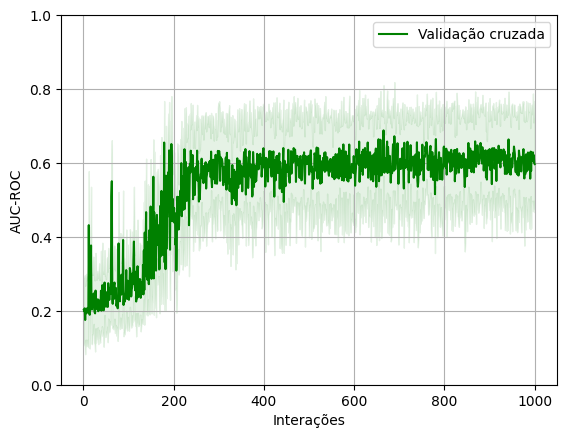

In [76]:
results_df_loda2 = df_results_loda[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_loda2, title="loda", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [77]:
df_results_loda = pd.read_csv('./metrics_skab/results_loda_cmaes_dwt.csv')   

df_results_loda['roc_auc_adjusted'] = df_results_loda['roc_auc_mean'] - df_results_loda['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_loda['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_loda.loc[999]
best_params = df_results_loda.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial               717.000000
roc_auc_mean          0.657332
roc_auc_std           0.086602
value                57.073029
contamination         0.002721
n_bins               51.000000
n_random_cuts       317.000000
roc_auc_adjusted      0.570730
Name: 717, dtype: float64


In [78]:
best_params_loda

{'contamination': 0.002721362871230859, 'n_bins': 51, 'n_random_cuts': 317}

In [79]:
n_random_cuts_best = int(best_params_loda.get('n_random_cuts'))
contamination_best = round(float(best_params_loda.get('contamination')), 5)
n_bins_best = int(best_params_loda.get('n_bins'))


print(f"Melhores hiperparâmetros encontrados: n_random_cuts={n_random_cuts_best}, contamination={contamination_best}, "
      f"n_bins={n_bins_best}")


Melhores hiperparâmetros encontrados: n_random_cuts=317, contamination=0.00272, n_bins=51


In [80]:
estimator = LODA(contamination=contamination_best, n_bins=n_bins_best, n_random_cuts=n_random_cuts_best)

pipe_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

pipe_model_loda.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LODA(contamination=0.00272, n_bins=51, n_random_cuts=317))])

In [81]:
scores_dev = pipe_model_loda.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 1): 0.0159, AUC: 0.8492
Melhore threshold:  0.015884637633110453


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.91824   0.75648   0.82955       193
         1.0    0.70625   0.89683   0.79021       126

    accuracy                        0.81191       319
   macro avg    0.81224   0.82665   0.80988       319
weighted avg    0.83451   0.81191   0.81401       319

Specificity: 0.7564766839378239
Gini:  0.6984949420182582
ROC AUC::  0.8492474710091291


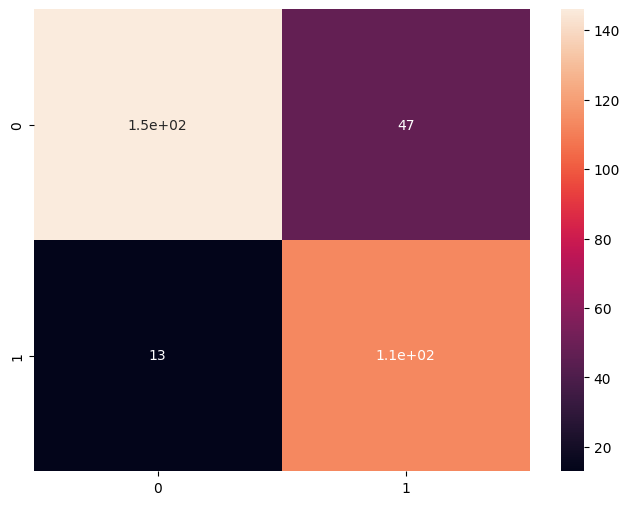

In [82]:
metrics(y_dev, y_pred, scores_dev)

In [83]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [84]:
scores_valid = pipe_model_loda.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = pipe_model_loda.predict(validation[feature_model])
# y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90698   0.82979   0.86667        47
         1.0    0.78378   0.87879   0.82857        33

    accuracy                        0.85000        80
   macro avg    0.84538   0.85429   0.84762        80
weighted avg    0.85616   0.85000   0.85095        80

Specificity: 0.8297872340425532
Gini:  0.703417150225661
ROC AUC::  0.8517085751128305


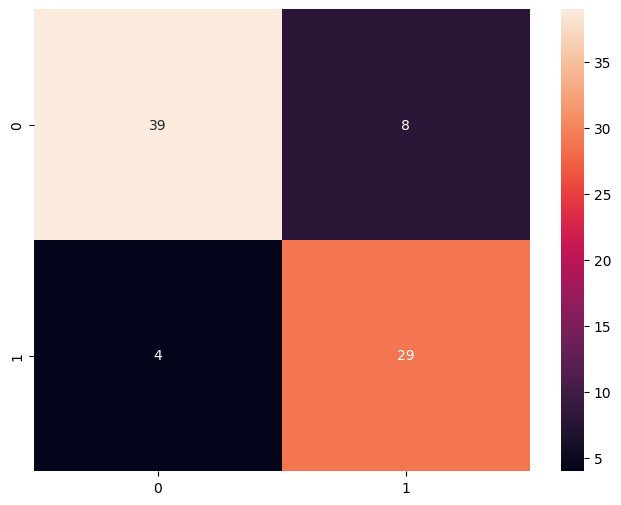

In [85]:
metrics(y_valid, y_pred, scores_valid)

In [86]:
with open('./models_skab/pipeline_LODA_cmaes_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_loda, file)

### OCSVM

In [87]:
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna

def build_ocsvm(params):
    model = OCSVM(
        kernel=params['kernel'],
        nu=params['nu'],
        gamma=params['gamma']
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

def transform_ocsvm_params(params):
    return {
        'kernel': params[0],
        'nu': float(params[1]),
        'gamma': float(params[2])
    }

def objective_ocsvm(trial, dataset, tscv, features):
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    nu = trial.suggest_float('nu', 0.0001, 0.005)
    gamma = trial.suggest_float('gamma', 0.001, 0.1)

    params = [kernel, nu, gamma]
    model_params = transform_ocsvm_params(params)
    model = build_ocsvm(model_params)

    mean_score, std_score = evaluate_model_pyod(model, dataset, tscv, features)

    trial.set_user_attr("roc_auc_mean", mean_score)
    trial.set_user_attr("roc_auc_std", std_score)

    return 100 * (mean_score - std_score)

def optuna_optimization_ocsvm(dataset, tscv, features, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler(), direction='maximize')
    study.optimize(lambda trial: objective_ocsvm(trial, dataset, tscv, features), n_trials=n_trials)
    return study.best_params, study


In [88]:
import time

start_time = time.time()  # Inicia o cronômetro

best_params_ocsvm, study_ocsvm = optuna_optimization_ocsvm(development, tscv, feature_model, n_trials=1000)
print(f"Melhores parâmetros para ocsvm: {best_params_ocsvm}")

total_time = time.time() - start_time  # Calcula o tempo total
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

[I 2025-10-10 22:15:12,238] A new study created in memory with name: no-name-9fdec6ed-ea83-4555-8421-2b5fc86c8c54
[I 2025-10-10 22:15:12,323] Trial 0 finished with value: 83.66801846675794 and parameters: {'kernel': 'rbf', 'nu': 0.0005867617384778521, 'gamma': 0.08925791688380667}. Best is trial 0 with value: 83.66801846675794.
[W 2025-10-10 22:15:12,328] The parameter 'kernel' in trial#1 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2025-10-10 22:15:12,416] Trial 1 finished with value: 13.087275674112247 and parameters: {'kernel': 'poly', 'nu': 0.00266627464070066, 'gamma': 0.0643149168380651}. Best is trial 0 with value: 83.66801846675794.
[W 2025-10-10 22:15:1

Melhores parâmetros para ocsvm: {'kernel': 'rbf', 'nu': 0.0018131307606885094, 'gamma': 0.07061223310703141}
Tempo total de execução: 55.82 segundos
Tempo total de execução: 0.93 minutos


In [89]:
data_metrics_ocsvm = []

for trial in study_ocsvm.trials:
    data_metrics_ocsvm.append({
        'trial': trial.number,
        'roc_auc_mean': trial.user_attrs.get('roc_auc_mean'),
        'roc_auc_std': trial.user_attrs.get('roc_auc_std'),
        'value': trial.value,
        **trial.params
    })

df_results_ocsvm = pd.DataFrame(data_metrics_ocsvm)
df_results_ocsvm.to_csv('./metrics_skab/results_ocsvm_cmaes_dwt.csv', index=False)
df_results_ocsvm.head()

,trial,roc_auc_mean,roc_auc_std,value,kernel,nu,gamma
0,0,0.882378,0.045698,83.668018,rbf,0.000587,0.089258
1,1,0.233754,0.102881,13.087276,poly,0.002666,0.064315
2,2,0.884347,0.037472,84.687450,rbf,0.001858,0.055652
3,3,0.886341,0.043161,84.318009,rbf,0.001757,0.039914
4,4,0.581036,0.218356,36.267955,linear,0.001673,0.043254


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

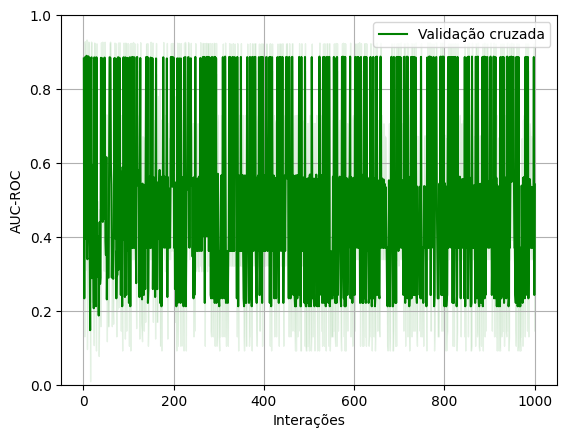

In [90]:
results_df_ocsvm2 = df_results_ocsvm[['roc_auc_mean', 'roc_auc_std']]

plot_learning_curve_cross_validation(results_df_ocsvm2, title="ocsvm", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [91]:
df_results_ocsvm = pd.read_csv('./metrics_skab/results_ocsvm_cmaes_dwt.csv')   

df_results_ocsvm['roc_auc_adjusted'] = df_results_ocsvm['roc_auc_mean'] - df_results_ocsvm['roc_auc_std']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = df_results_ocsvm['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = df_results_ocsvm.loc[999]
best_params = df_results_ocsvm.loc[best_params_idx]  

print("\nMétricas:", best_params) 


Métricas: trial                    197
roc_auc_mean        0.886589
roc_auc_std         0.036398
value                85.0191
kernel                   rbf
nu                  0.001813
gamma               0.070612
roc_auc_adjusted    0.850191
Name: 197, dtype: object


In [92]:
kernel_best = best_params_ocsvm.get('kernel')
nu_best = round(float(best_params_ocsvm.get('nu')), 5)
gamma_best = round(float(best_params_ocsvm.get('gamma')), 3)

print(f"Melhores hiperparâmetros encontrados: kernel={kernel_best}, nu={nu_best}, gamma={gamma_best}")


Melhores hiperparâmetros encontrados: kernel=rbf, nu=0.00181, gamma=0.071


In [93]:
estimator = OCSVM(
    kernel=kernel_best,
    nu=nu_best,
    gamma=gamma_best
)


In [94]:
pipe_model_ocsvm = Pipeline([
    ('scaler', StandardScaler()),
    ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
    ('estimator', estimator)
])

# Treinar no conjunto sem anomalias
pipe_model_ocsvm.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.071,
   kernel='rbf', max_iter=-1, nu=0.00181, shrinking=True, tol=0.001,
   verbose=False))])

In [95]:
scores_dev = pipe_model_ocsvm.decision_function(X_dev)

# Encontrar o melhor threshold
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

# Prever usando o threshold escolhido
y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhor threshold: ", best_threshold)

# y_pred = pipe_model_ocsvm.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)

Melhor Threshold (FPR ≤ 1): 0.0043, AUC: 0.8938
Melhor threshold:  0.004273704995729155


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.86161   1.00000   0.92566       193
         1.0    1.00000   0.75397   0.85973       126

    accuracy                        0.90282       319
   macro avg    0.93080   0.87698   0.89269       319
weighted avg    0.91627   0.90282   0.89962       319

Specificity: 1.0
Gini:  0.7876470104449378
ROC AUC::  0.8938235052224689


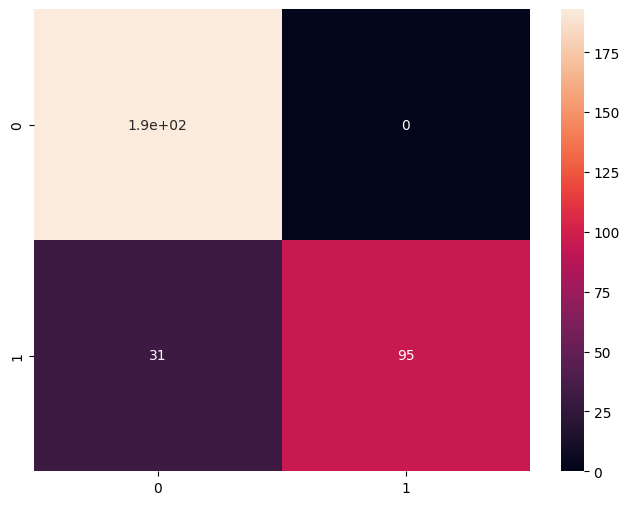

In [96]:
metrics(y_dev, y_pred, scores_dev)

In [97]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [98]:
scores_valid = pipe_model_ocsvm.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)


# y_pred = pipe_model_ocsvm.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.87500   0.74468   0.80460        47
         1.0    0.70000   0.84848   0.76712        33

    accuracy                        0.78750        80
   macro avg    0.78750   0.79658   0.78586        80
weighted avg    0.80281   0.78750   0.78914        80

Specificity: 0.7446808510638298
Gini:  0.7691811734364926
ROC AUC::  0.8845905867182463


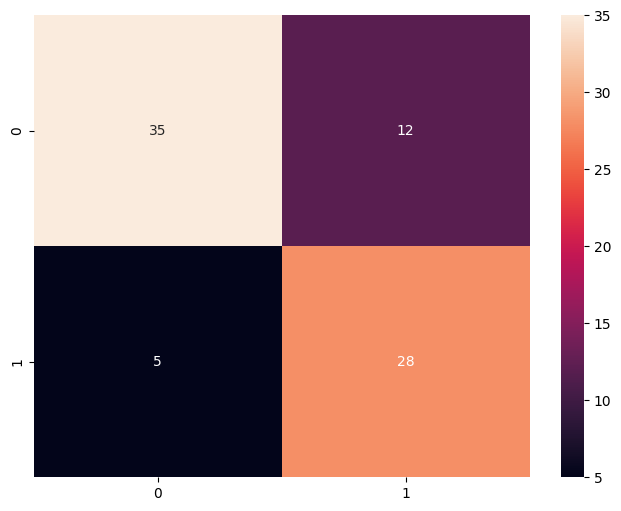

In [99]:
metrics(y_valid, y_pred, scores_valid)

In [100]:
with open('./models_skab/pipeline_OCSVM_cmaes_dwt.pkl', 'wb') as file: 
    pickle.dump(pipe_model_ocsvm, file)